### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

import miceforest as mf

import lightgbm
import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# My functions 
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # Ub01
# results_dir = "/home/mm/Tesis/pred_results/" # Ub01

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'br_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory created!
Directory created!


In [4]:
for i in ['RandomForest', 'SVM_rbf', 'SVM_poly', 'LightGBM', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!
Directory created!
Directory created!


In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1290, 45), (321, 45))

In [6]:
####   Separated df between train and test (25%)
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = train.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})

In [7]:
# MICE Imputation

kernel= mf.ImputationKernel(data, datasets=3, save_all_iterations=True, random_state=123)
# Run MICE
kernel.mice(3)
data = kernel.complete_data(dataset=3-1)
#### #### ####
kernel= mf.ImputationKernel(unseen_data, datasets=3, save_all_iterations=True, random_state=123)
# Run MICE
kernel.mice(3)
unseen_data = kernel.complete_data(dataset=3-1)

### Tiramos contry of residence y nationality
data.drop(['nationality', 'country_of_residence'], axis=1, inplace=True)
unseen_data.drop(['nationality', 'country_of_residence'], axis=1, inplace=True)

In [8]:
print(data.shape, unseen_data.shape)
print(data.isna().sum().sum(), unseen_data.isna().sum().sum())

(865, 40) (865, 40)
0 0


In [9]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh


In [10]:
print(f"Data to Train: {len(data)}n\Out of sample data: {len(unseen_data)}")

Data to Train: 865n\Out of sample data: 865


In [11]:
### Load Hyperparams
# hparams_path = "/home/mm/Tesis/pred_results/2023-07-14/mean_hparams/" # ssh

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-07-15/mean_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

rbf_hp = pd.read_csv(hparams_path + "SVC_RBF_hparams2.csv",
                     usecols=['param_C', 'param_gamma','params', 'mean_test_score' ,'mean_train_score'])
rbf_hp= rbf_hp[rbf_hp['mean_test_score'] < rbf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

lgbm_hp = pd.read_csv(hparams_path + "lgbm_hparams.csv", usecols=[ 'param_learning_rate', 'param_max_depth',
       'param_n_estimators', 'param_num_leaves', 'param_reg_alpha',
       'param_reg_lambda','params', 'mean_test_score' ,'mean_train_score'])
lgbm_hp= lgbm_hp[lgbm_hp['mean_test_score'] < lgbm_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

In [12]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[0,'param_n_estimators'],
    "criterion": rf_hp.loc[0,'param_criterion'],
    "max_depth": rf_hp.loc[0,'param_max_depth'],
    "min_samples_split": rf_hp.loc[0,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[0,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[0,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}
#RBF
rbf_params = {'C': rbf_hp.loc[0, "param_C"],
              'gamma': rbf_hp.loc[0, "param_gamma"],
              "kernel":"rbf","class_weight":"balanced", "verbose":0}
#Poly
poly_params = {'C': poly_hp.loc[0, "param_C"],
              'gamma': poly_hp.loc[0, "param_gamma"],
               'coef0': poly_hp.loc[0, "param_coef0"],
               'degree': poly_hp.loc[0, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}
#LGBM
lgbm_params ={'num_leaves': lgbm_hp.loc[0, 'param_num_leaves'],
    'max_depth': lgbm_hp.loc[0, 'param_max_depth'],
    'learning_rate':lgbm_hp.loc[0, 'param_learning_rate'],
    'n_estimators': lgbm_hp.loc[0, 'param_n_estimators'],
    'reg_alpha':lgbm_hp.loc[0, 'param_reg_alpha'],
    'reg_lambda':lgbm_hp.loc[0, 'param_reg_lambda'],
    'subsample':1.0,
    'subsample_freq':-1,
    'objective':'binary',
    'n_jobs': -1,
    'verbose':-1}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[0, 'param_booster'],
    'tree_method': xgb_hp.loc[0, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[0, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[0, 'param_max_depth'],
    'max_bin': xgb_hp.loc[0, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[0, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[0, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[0, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[0, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

### RF Model

##### Bootstrap

In [13]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=5000, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=14, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|█████████████████| 5000/5000 [1:23:53<00:00,  1.01s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:83.88854464292527 minutes
empirical p-value: 0.0


In [14]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-07-27/br_res'

In [15]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.815430
ROC_AUC        0.841219
Precision      0.608977
Recall         0.636483
Sensitivity    0.636483
Specificity    0.871012
F1             0.620060
Efron_pR2      0.253872
dtype: float64

In [16]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8412


In [17]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010753,0.01013,0.013526,0.013333,0.013333,0.009291,0.013454,0.012064


In [18]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
37,year_birth,0.249654,0.015094
5,cdr_global,0.065255,0.008493
38,years_education,0.062561,0.009753
23,income_s_NaN,0.045459,0.008330
25,mini_sea_total,0.044700,0.004347
1,ace_lw,0.043455,0.006563
6,cdr_sumofboxes,0.041406,0.003949
11,ifs_total_score,0.039049,0.003899
7,cognition,0.036347,0.004440
3,aceiii_total,0.034634,0.004299


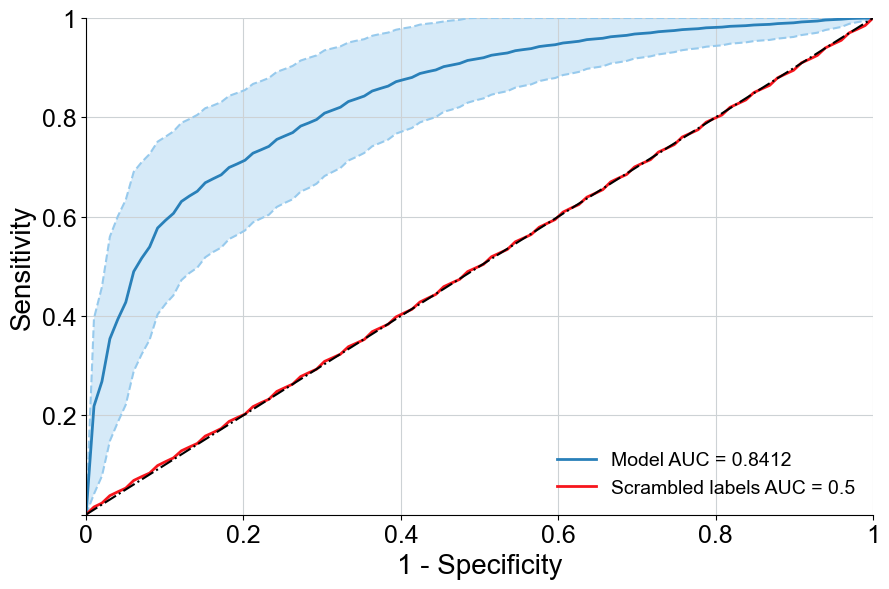

In [19]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


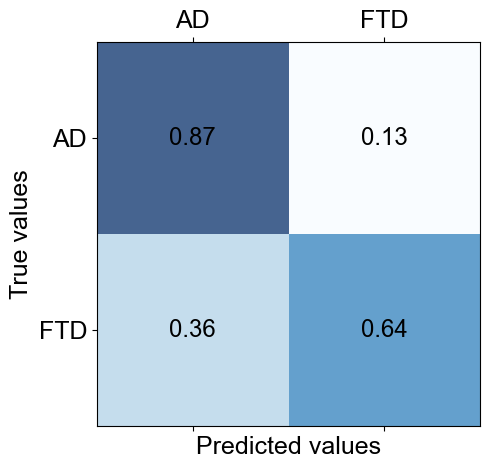

In [20]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [21]:
rf_fimp = bc.permutation_FIMP( data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.3, n_repeats=1000, random_state=123)

/home/marcelo/GitRepos/Tesis/code/ml_bootstrap_clf.py:1388: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(X_train, y_train)


In [22]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
rf_fimp.sort_values('mean', ascending=False).head()

,predictor,mean,std
0,year_birth,0.154805,0.028934
11,cdr_global,0.028696,0.011401
27,income_s_NaN,0.021024,0.007480
2,years_education,0.013521,0.002987
7,mini_sea_total,0.005640,0.002946


In [23]:
# ml_plotting.plot_permutation_FIMP(rf_fimp, names='variables', importances_col='Importance_mean', std_col='Importance_std')

In [24]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
37,year_birth,0.249654,0.015094
5,cdr_global,0.065255,0.008493
38,years_education,0.062561,0.009753
23,income_s_NaN,0.045459,0.008330
25,mini_sea_total,0.044700,0.004347


##### unseen data

In [25]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [26]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

/tmp/ipykernel_2534455/2748179169.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [27]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [28]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8852
Accuracy: 0.8971
Recall: 0.8627
F1: 0.7982
Precision:0.7426


In [29]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8852
Bootstrping test ROC score: 	0.8412


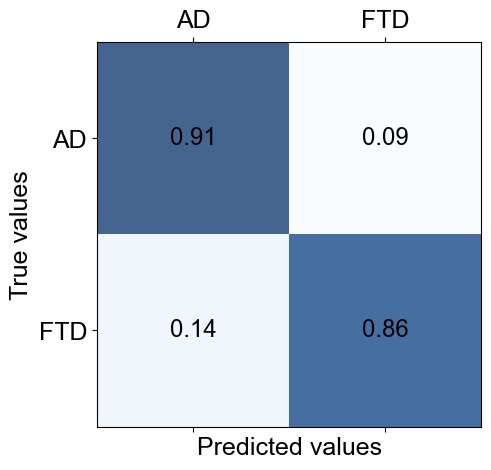

In [30]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### SVM - RBF

##### Bootstrap

In [31]:
rbf_Model_res, rbf_CI_df, rbf_Model_res_r, rbf_ROC_AUC, rbf_CM, rbf_ROC_chance, rbf_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=rbf_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

SVC(C=6.583759171209091, class_weight='balanced', gamma=0.1103307048797783,
    verbose=0)


Iterating: 100%|███████████████████| 5000/5000 [03:43<00:00, 22.37it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.725129536787669 minutes
empirical p-value: 0.0


In [32]:
rbf_Model_res.to_csv(path_res+ "/SVM_rbf/rbf_Model_res.csv", index=False)
rbf_Model_res.mean()

Accuracy       0.789694
ROC_AUC        0.771017
Precision      0.543841
Recall         0.735512
Sensitivity    0.735512
Specificity    0.806523
F1             0.623696
dtype: float64

In [33]:
rbf_CI_df.to_csv(path_res+ "/SVM_rbf/rbf_CI_df.csv", index=False)
rbf_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci
0,0.011296,0.011647,0.013806,0.012226,0.012226,0.01095,0.013428


In [34]:
rbf_Model_res_r

'Variables importances is not computed, no .coef or .importances for non linear SVM'

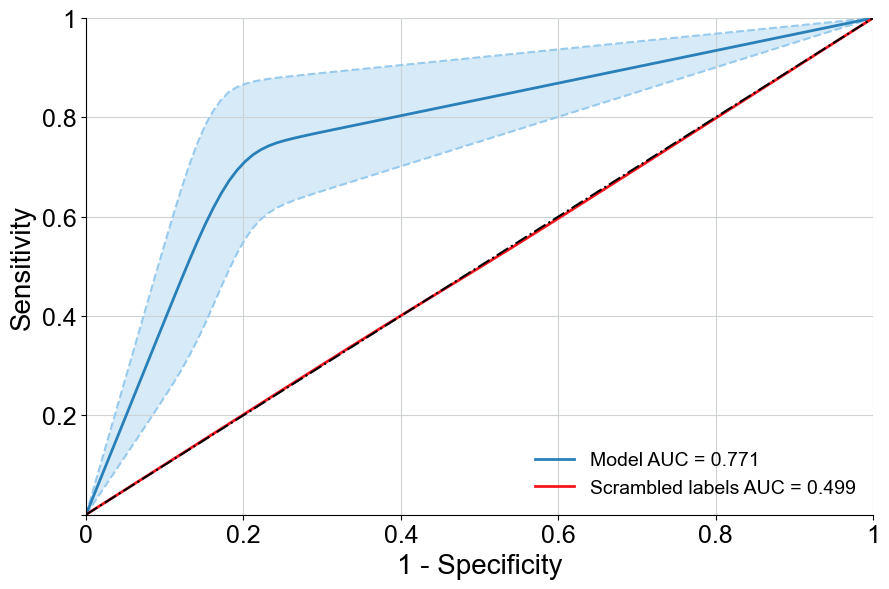

In [35]:
ml_plotting.plot_custom_roc_curve(rbf_ROC_AUC, rbf_ROC_chance, fname=path_res+ "/SVM_rbf/rbf_ROC_AUC_curve.png")

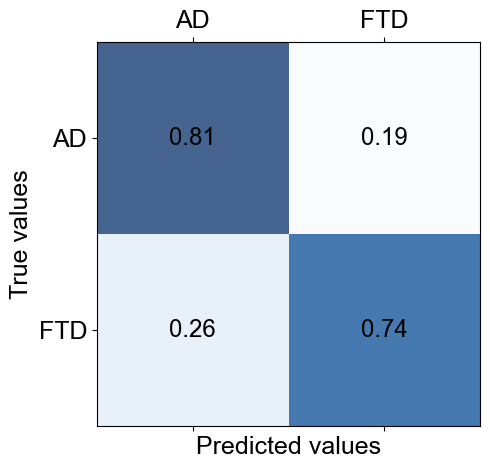

In [36]:
ml_plotting.plot_boostrap_CM(rbf_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_rbf/rbf_CM.png")

#### Permutation Feature importance

In [37]:
rbf_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=rbf_params, test_size=.3, n_repeats=1000, random_state=123)

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
rbf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_rbf/rbf_PFI.csv")
rbf_fimp.sort_values('mean', ascending=False)

,predictor,mean,std
24,ace_lw,9.878009e-02,0.029255
23,ace_vs,9.133953e-02,0.029298
4,aceiii_total,8.415504e-02,0.029330
0,year_birth,7.316801e-02,0.028773
9,pfeffer_total,5.881526e-02,0.024524
6,ifs_total_score,4.276151e-02,0.023887
7,mini_sea_total,4.082210e-02,0.022246
3,moca_total,2.543381e-02,0.019788
10,cdr_sumofboxes,2.516122e-02,0.018292
2,years_education,2.308765e-02,0.019029


#### Unseen data

In [39]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [40]:
#Predict
svc_rbf = SVC(**rbf_params)
svc_rbf.fit(X_train, y_train)
y_pred = svc_rbf.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/SVM_rbf/rbf_unseen.csv")

In [42]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{rbf_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 1.0
Accuracy: 1.0
Recall: 1.0
F1: 1.0
Precision:1.0
Unseen Data ROC score: 		1.0
Bootstrping test ROC score: 	0.7710


### SVM - Poly

#### Bootstrap

In [43]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

SVC(C=0.001, class_weight='balanced', coef0=0, degree=2,
    gamma=4.163139933941838, kernel='poly', verbose=0)


Iterating: 100%|███████████████████| 5000/5000 [03:06<00:00, 26.79it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.1108954389890036 minutes
empirical p-value: 0.0


In [44]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.795334
ROC_AUC        0.771129
Precision      0.554300
Recall         0.725112
Sensitivity    0.725112
Specificity    0.817145
F1             0.626734
dtype: float64

In [45]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.011183
ROC_AUC_ci        0.011645
Precision_ci      0.013777
Recall_ci         0.012375
Sensitivity_ci    0.012375
Specificity_ci    0.010715
F1_ci             0.013407
dtype: float64

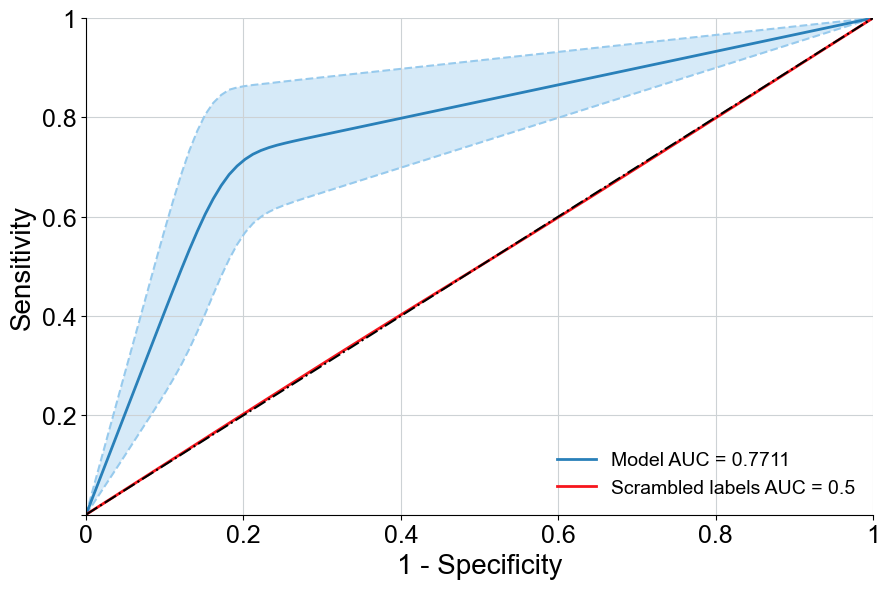

In [46]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

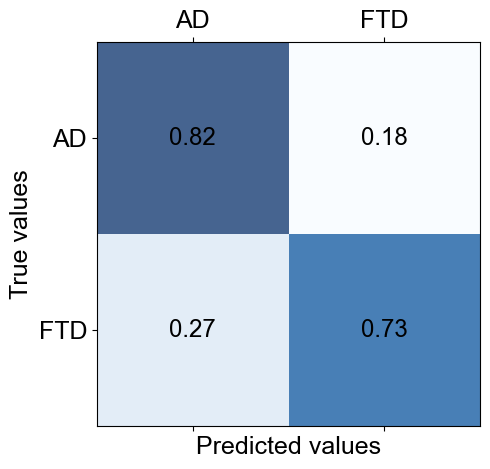

In [47]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [48]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=1000, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
p_fimp.sort_values('mean', ascending=False)

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,predictor,mean,std
24,ace_lw,0.268950,0.028980
23,ace_vs,0.197406,0.028071
0,year_birth,0.117047,0.021127
11,cdr_global,0.115210,0.023110
3,moca_total,0.085570,0.021814
22,moca_lw,0.055096,0.016576
21,moca_vs,0.055096,0.016576
36,income_s_9,0.038943,0.013217
4,aceiii_total,0.035209,0.015593
19,mmse_vs,0.028483,0.014587


#### Unseen data

In [49]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [50]:
poly = SVC(**poly_params)
poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [52]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.7768
Accuracy: 0.7676
Recall: 0.7941
F1: 0.6171
Precision:0.5047
Unseen Data ROC score: 		0.7768
Bootstrping test ROC score: 	0.7711


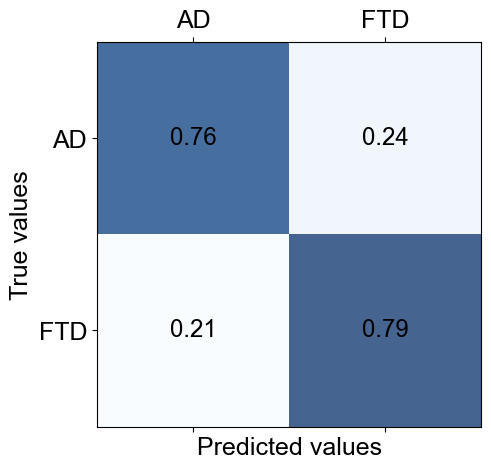

In [53]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### LightGBM

#### Bootstrap

In [54]:
lgb_Model_res, lgb_CI_df, lgb_Model_res_r, lgb_ROC_AUC, lgbCM, lgb_ROC_chance, lgb_empirical_p_value, _ = bc.Bootstrap_LGBM_classifier(
    data, 'diagnosis',  params=lgbm_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

Iterating: 100%|███████████████████| 5000/5000 [07:24<00:00, 11.24it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:7.415292231241862 minutes
empirical p-value: 0.0


In [55]:
lgb_Model_res.to_csv(path_res+ "/LightGBM/lgb_Model_res.csv", index=False)
lgb_Model_res.mean()

Accuracy       0.837614
ROC_AUC        0.844696
Precision      0.720184
Recall         0.522732
Sensitivity    0.522732
Specificity    0.935418
F1             0.602354
Efron_pR2      0.336681
dtype: float64

In [56]:
lgb_CI_df.to_csv(path_res+ "/LightGBM/lgb_CI_df.csv", index=False)
lgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010223,0.01004,0.012443,0.013845,0.013845,0.006813,0.013566,0.013099


In [57]:
lgb_Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+"/LightGBM/lgb_CI_df.csv", index=False)
lgb_Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
5,cdr_global,20.5536,2.287482
37,year_birth,19.5238,2.678296
25,mini_sea_total,15.1988,3.390749
11,ifs_total_score,15.1380,3.320958
38,years_education,14.3490,3.098374
7,cognition,12.9208,3.317398
6,cdr_sumofboxes,12.3220,3.100296
34,npi_total_caregiver,9.1478,3.144254
3,aceiii_total,9.1450,2.884448
33,npi_total,8.8270,3.092990


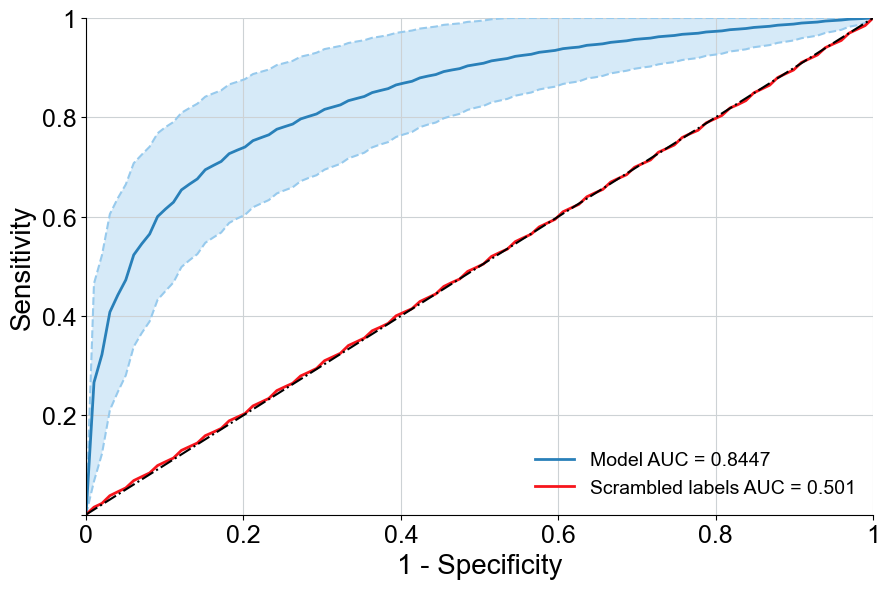

In [58]:
ml_plotting.plot_custom_roc_curve(lgb_ROC_AUC, lgb_ROC_chance, fname=path_res+ "/LightGBM/lgb_ROC.png")

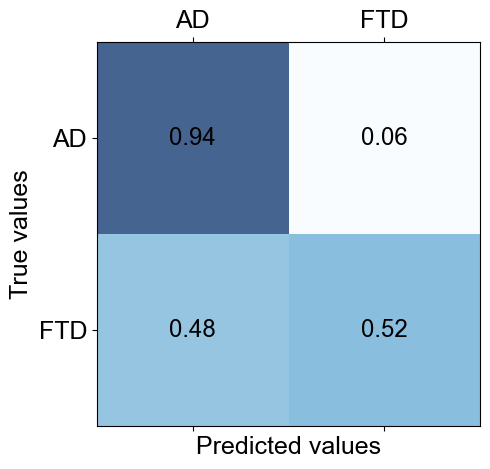

In [59]:
ml_plotting.plot_boostrap_CM(lgbCM, labels=['AD', 'FTD'],fname=path_res+ "/LightGBM/lgb_CM.png")

#### Permutation Feature importance

In [60]:
lgb_fimp = bc.permutation_FIMP( data, 'diagnosis', lightgbm.LGBMClassifier(), params=lgbm_params, test_size=.3, n_repeats=1000, random_state=123)
lgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/LightGBM/lgb_PFI.csv")
lgb_fimp.sort_values('mean', ascending=False).head()

,predictor,mean,std
0,year_birth,0.132837,0.025874
11,cdr_global,0.051419,0.014414
27,income_s_NaN,0.035296,0.012046
36,income_s_9,0.016043,0.006115
2,years_education,0.011298,0.004182


#### Unseen data

In [61]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [62]:
lgb = lightgbm.LGBMClassifier(**lgbm_params)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [63]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/LightGBM/lgb_PFI.csv")

In [64]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.8561
Accuracy: 0.9225
Recall: 0.7304
F1: 0.8164
Precision:0.9255
Unseen Data ROC score: 		0.8561
Bootstrping test ROC score: 	0.8447


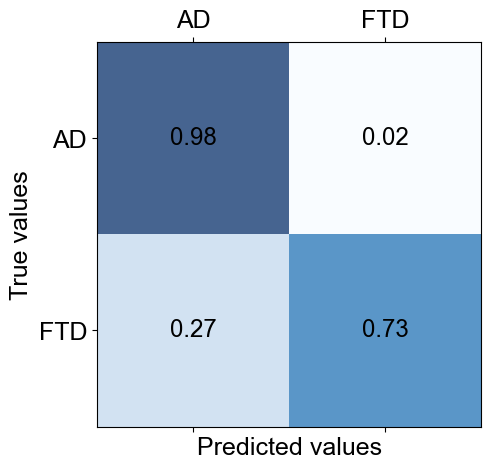

In [65]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### XGBoost

#### Bootstrap

In [66]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

Iterating: 100%|███████████████████| 5000/5000 [32:29<00:00,  2.57it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:32.486235558986664 minutes
empirical p-value: 0.0


In [67]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.831840
ROC_AUC        0.843182
Precision      0.702196
Recall         0.512927
Sensitivity    0.512927
Specificity    0.930897
F1             0.589435
Efron_pR2      0.328271
dtype: float64

In [68]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
5,cdr_global,49.147000,4.254293,4.691811,0.421837
29,year_birth,40.570600,4.659330,8.580569,1.030213
11,ifs_total_score,27.860000,6.092735,1.918442,0.369175
30,years_education,27.740800,5.102198,3.103876,0.624825
19,mini_sea_total,21.645200,5.711063,1.924776,0.422074
25,npi_total,17.590800,5.600967,1.701693,0.363031
17,income_s_NaN,17.043800,2.821467,8.115346,1.252082
24,n_children,16.213600,5.488169,1.411114,0.270812
26,npi_total_caregiver,13.902161,5.250026,1.703956,0.407210
3,aceiii_total,13.830400,5.111209,4.161558,1.575172


In [69]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010367,0.010079,0.012676,0.013855,0.013855,0.00703,0.013636,0.013016


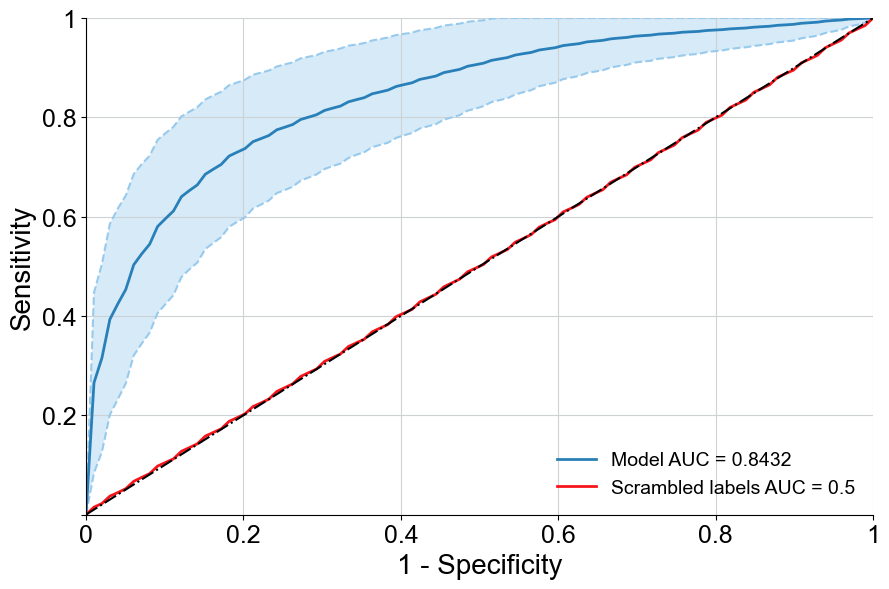

In [70]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

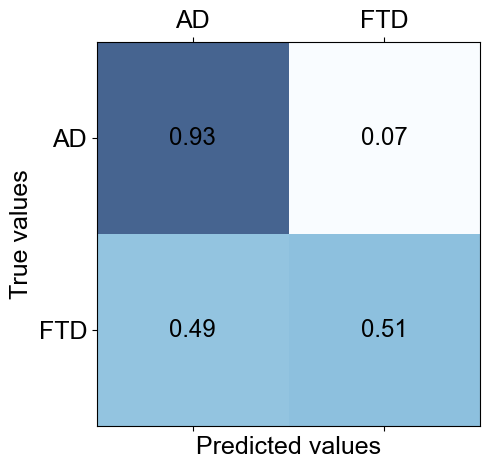

In [71]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [72]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
xgb_fimp.sort_values('mean', ascending=False)

,predictor,mean,std
0,year_birth,0.141574,0.031331
11,cdr_global,0.057953,0.016391
27,income_s_NaN,0.034969,0.010143
2,years_education,0.015830,0.005066
20,mmse_lw,0.013003,0.008080
36,income_s_9,0.009145,0.004347
6,ifs_total_score,0.004368,0.004220
1,sex,0.003805,0.001585
10,cdr_sumofboxes,0.001243,0.001480
5,mmse_total,0.001217,0.001771


#### Unseen data

In [73]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [74]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [75]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [76]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.7816
Accuracy: 0.8786
Recall: 0.598
F1: 0.6991
Precision:0.8414
Unseen Data ROC score: 		0.7816
Bootstrping test ROC score: 	0.8432


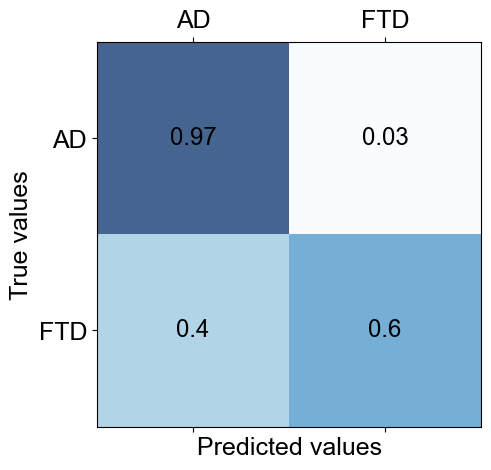

In [77]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])